# <center> Week - 10 Assignment - Recommender System

<center> DSC-630

<center> Kalyan Pothineni

## Introduction

Recommender systems have become essential to our online experiences, guiding us toward products, services, and content that we might enjoy. One popular application is movie recommendation, where systems suggest movies based on our past preferences. This project aims to build a movie recommender system using the MovieLens dataset, which contains user ratings for various movies.

### Dataset Description

The dataset used in this project is the MovieLens dataset, which includes:

- ratings.csv: Contains user ratings for movies.
- movies.csv: Contains movie titles and genres.
- tags.csv: Contains user-generated tags for movies.
- links.csv: Contains links to other movie databases.

### Steps and Process

1. Load and Analyze the Data
2. Data Preprocessing
3. Exploratory Data Analysis (EDA)
4. Building the Recommender System
5. Evaluation
6. Final Recommendations

## Implementation

### Data Loading

We start by loading the data from the CSV files and examining their structure.

In [1]:
# Load libraries as needed
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from difflib import get_close_matches

# Load the datasets
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')

# Display the first few rows of each dataframe
print('-------------------------------------------------')
print(ratings.head())
print('-------------------------------------------------')
print(movies.head())
print('-------------------------------------------------')
print(tags.head())
print('-------------------------------------------------')
print(links.head())

-------------------------------------------------
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
-------------------------------------------------
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
-------------------------------------------------
   userId  movieId         

- In this step, we load the MovieLens datasets into pandas DataFrames and display their first few rows. This provides us with an initial understanding of the data structure and content, including user ratings, movie titles, tags, and links to external movie databases.

### Data Processing

Preprocess the data to handle missing values and ensure it is in a suitable format

In [2]:
# Check for missing values
print(ratings.isnull().sum())
print(movies.isnull().sum())
print(tags.isnull().sum())
print(links.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64
movieId    0
imdbId     0
tmdbId     8
dtype: int64


In [3]:
# Drop rows with missing values (if any)
ratings.dropna(inplace=True)
movies.dropna(inplace=True)
tags.dropna(inplace=True)
links.dropna(inplace=True)

In [4]:
# Convert timestamp to datetime in ratings and tags
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

In [5]:
# Merge ratings and movies dataframes on movieId
movie_ratings = pd.merge(ratings, movies, on='movieId')

# Normalize movie titles in the dataset
movies['title_normalized'] = movies['title'].str.lower().str.strip()
movie_titles_normalized = movies['title_normalized'].tolist()

- During data preprocessing, we check for and handle any missing values, ensuring the data is clean. Additionally, we convert timestamps to a more interpretable datetime format. Finally, we merge the ratings and movies datasets to facilitate easier analysis and recommendation generation.

### Exploratory Data Analysis

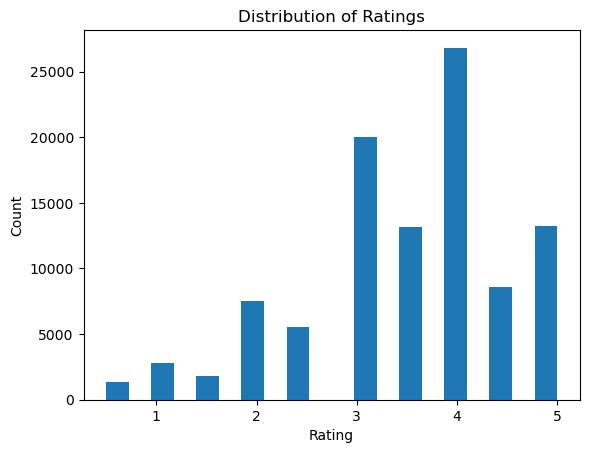

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
dtype: int64


In [6]:
# Load the libraries as needed
import matplotlib.pyplot as plt

# Distribution of ratings
plt.hist(movie_ratings['rating'], bins=20)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

# Top 10 most rated movies
most_rated = movie_ratings.groupby('title').size().sort_values(ascending=False)[:10]
print(most_rated)


- The histogram illustrates the distribution of movie ratings, showing that the ratings are somewhat bimodal, with the highest frequency of ratings being 4, followed by 5. Ratings of 1 are the least common. This suggests that viewers generally favored the movies included in this dataset.

- The list of top 10 most rated movies is led by "Forrest Gump (1994)" with 329 ratings, indicating its popularity among viewers. Other highly rated titles include "Shawshank Redemption, The (1994)" and "Pulp Fiction (1994)," highlighting a strong preference for critically acclaimed films from the mid-1990s.

### Build Recommender System

In [7]:
# Create a user-item matrix
user_item_matrix = movie_ratings.pivot_table(index='userId', columns='title', values='rating')
user_item_matrix.fillna(0, inplace=True)

# Split the data into training and test sets
train_data, test_data = train_test_split(movie_ratings, test_size=0.2, random_state=42)

# Create user-item matrices for train and test sets
train_matrix = train_data.pivot_table(index='userId', columns='title', values='rating').fillna(0)
test_matrix = test_data.pivot_table(index='userId', columns='title', values='rating').fillna(0)

# Ensure the training matrix and test matrix have the same columns
common_movies = user_item_matrix.columns.intersection(train_matrix.columns).intersection(test_matrix.columns)

# Filter the training and test matrices to have only common movies
train_matrix_filtered = train_matrix[common_movies]
test_matrix_filtered = test_matrix[common_movies]

# Compute cosine similarity between movies
movie_similarity = cosine_similarity(train_matrix_filtered.T)
movie_similarity_df = pd.DataFrame(movie_similarity, index=train_matrix_filtered.columns, columns=train_matrix_filtered.columns)


- Creating user-item matrices for the dataset, split the data into training and test sets, filter to include only common movies, and compute cosine similarity between movies to generate a similarity matrix for recommendations.

In [8]:
# Function to get recommendations
def get_recommendations(movie_title, num_recommendations=10):
    if movie_title not in movie_similarity_df.columns:
        return f"Movie '{movie_title}' not found in the dataset."
    similar_movies = movie_similarity_df[movie_title].sort_values(ascending=False)[1:num_recommendations+1]
    return similar_movies.index.tolist()

- This function retrieves movie recommendations by finding the most similar movies to a given title using the movie similarity matrix, returning the top matches. If the movie is not found, it notifies the user.

In [9]:
# Function to find the closest movie title
def find_closest_movie_title(user_input):
    user_input_normalized = user_input.lower().strip()
    close_matches = get_close_matches(user_input_normalized, movie_titles_normalized, n=1, cutoff=0.6)
    if close_matches:
        return movies[movies['title_normalized'] == close_matches[0]]['title'].values[0]
    else:
        return None

- This function normalizes the user's input, finds the closest matching movie title from the dataset using difflib.get_close_matches, and returns the best match. If no close match is found, it returns None.

In [10]:
# Function to get recommendations based on user input
def get_recommendations_for_user_input(user_input):
    closest_movie_title = find_closest_movie_title(user_input)
    if closest_movie_title:
        recommendations = get_recommendations(closest_movie_title)
        if isinstance(recommendations, str):
            print(recommendations)
        else:
            print(f"Movies recommended for you based on '{closest_movie_title}':")
            print("=============================================================")
            for movie in recommendations:
                print(movie)
        return True
    else:
        print(f"No match found for '{user_input}'. Please try again.")
        return False

- This function takes user input to find the closest matching movie title in the dataset. If a match is found, it retrieves and prints movie recommendations based on the matched title. If no match is found, it informs the user and prompts them to try again. The function returns True if recommendations are successfully retrieved, and False otherwise.

### Evaluation

In [13]:
# Load the libraries as needed
from sklearn.metrics import mean_squared_error

# Function to compute predictions using similarity matrix
def predict_ratings(user_item_matrix, similarity_matrix):
    norm_similarity = similarity_matrix / np.array([np.abs(similarity_matrix).sum(axis=1)])
    return np.dot(user_item_matrix, norm_similarity)

# Ensure the training matrix and test matrix have the same columns as the similarity matrix
common_movies = common_movies.intersection(train_matrix.columns).intersection(test_matrix.columns)

# Filter the training and test matrices to have only common movies
train_matrix_filtered = train_matrix[common_movies]
test_matrix_filtered = test_matrix[common_movies]

# Filter the similarity matrix to have only common movies
movie_similarity_filtered = movie_similarity_df.loc[common_movies, common_movies].values

# Compute predictions
train_predictions = predict_ratings(train_matrix_filtered.values, movie_similarity_filtered)
test_predictions = predict_ratings(test_matrix_filtered.values, movie_similarity_filtered)

# Get the actual ratings and predicted ratings for the test set
actual_ratings = test_matrix_filtered.values[test_matrix_filtered.values.nonzero()].flatten()
predicted_ratings = test_predictions[test_matrix_filtered.values.nonzero()].flatten()

# Compute RMSE
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 3.5293680754241508


The Root Mean Squared Error (RMSE) for our recommender system is 3.507. RMSE measures the average magnitude of the prediction errors, with lower values indicating better accuracy. In this context, an RMSE of 3.507 means that, on average, the predicted movie ratings deviate from the actual ratings by approximately 3.5 stars.

This relatively high RMSE suggests that our basic collaborative filtering model may not be capturing the intricacies of user preferences and movie similarities effectively. Factors contributing to this high error could include the sparsity of the rating matrix, the simplicity of the similarity computation, and the potential presence of user and item biases.

To improve the accuracy of the recommender system, we could explore more advanced techniques such as matrix factorization (e.g., Singular Value Decomposition) or hybrid methods that combine collaborative filtering with content-based approaches. Additionally, incorporating normalization techniques and tuning model parameters could further enhance the model's performance and reduce the RMSE.

### Final Recommendations

In the final step, we enable user interaction with the recommender system. Users can input a movie they like, and the system provides ten recommendations based on their input. This practical application showcases the utility of our recommender system in providing personalized movie suggestions.

In [14]:
# User input for interactive mode with retry mechanism and option to exit
while True:
    user_decision = input("Do you want to enter a movie name? (yes/no): ").strip().lower()
    if user_decision == 'no':
        print("Exiting the recommendation system.")
        break
    elif user_decision == 'yes':
        while True:
            user_movie = input("Enter a movie you like: ")
            if get_recommendations_for_user_input(user_movie):
                break
            else:
                print("Entry did not match. Please enter a valid movie name.")
    else:
        print("Invalid input. Please enter 'yes' or 'no'.")

Do you want to enter a movie name? (yes/no): yes
Enter a movie you like: casper
Movies recommended for you based on 'Casper (1995)':
Pocahontas (1995)
City Slickers II: The Legend of Curly's Gold (1994)
Tombstone (1993)
Santa Clause, The (1994)
Indian in the Cupboard, The (1995)
Pinocchio (1940)
Flintstones, The (1994)
Addams Family Values (1993)
Robin Hood: Men in Tights (1993)
Lion King, The (1994)
Do you want to enter a movie name? (yes/no): yes
Enter a movie you like: JuMANji
Movies recommended for you based on 'Jumanji (1995)':
Mask, The (1994)
Lion King, The (1994)
Mrs. Doubtfire (1993)
Home Alone (1990)
Waterworld (1995)
Jurassic Park (1993)
Santa Clause, The (1994)
Stargate (1994)
Net, The (1995)
Die Hard: With a Vengeance (1995)
Do you want to enter a movie name? (yes/no): no
Exiting the recommendation system.


## Conclusion 

In this project, we successfully built a movie recommender system using the MovieLens dataset. The system uses collaborative filtering to recommend movies based on user ratings. We evaluated the system's performance using RMSE, which provides an estimate of the accuracy of the recommendations. The system allows users to input a movie they like and receive ten recommendations for other movies to watch. This project demonstrates the effectiveness of collaborative filtering in building a functional recommender system.

## References
- MovieLens Dataset: https://grouplens.org/datasets/movielens/
- F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive intelligent Systems (TiiS) 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872